In [1]:
import numpy as np
import cv2
import pickle
# import matplotlib.image as mpimg
from collections import deque
from skimage.feature import hog

from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
%matplotlib inline

# import utils
from utils import *

## Load camera for undistortion

In [2]:
pickle_file = 'camera.p'

try:
    with open(pickle_file, 'rb') as pfile:
        data = pickle.load(pfile)
        print(pickle_file,' Loaded...')
except Exception as e:
    print('Unable to Load data to', pickle_file, ':', e)
    raise
    
camera = data['camera']

camera.p  Loaded...


## Load classifier

In [3]:
pickle_file = 'Classifier_9921.p'
try:
    with open(pickle_file, 'rb') as pfile:
        data = pickle.load(pfile)
        print(pickle_file,' Loaded...')
except Exception as e:
    print('Unable to Load data to', pickle_file, ':', e)
    raise    
    
color_space = data['color_space']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data['cell_per_block']
hog_channel = data['hog_channel']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
spatial_feat = data['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']
X_scaler = data['X_scaler']
clf = data['clf']

Classifier_9921.p  Loaded...


## Define sliding windows function

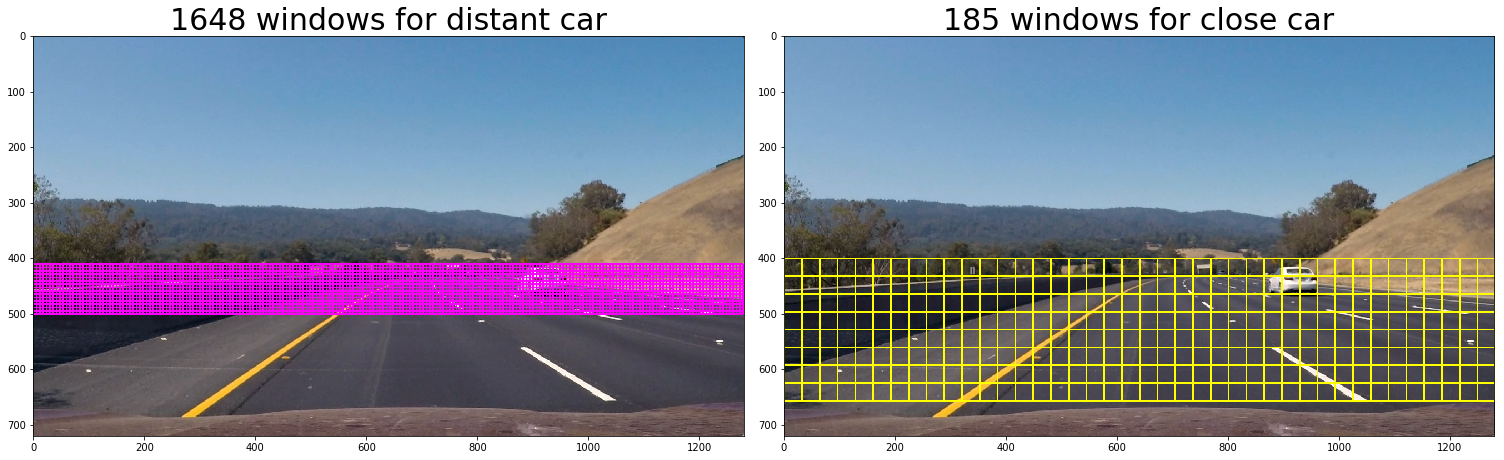

In [4]:
img = cv2.cvtColor(cv2.imread('../test_images/test3.jpg'),cv2.COLOR_BGR2RGB)        
  
# Define a single function that can extract features using hog sub-sampling and make predictions
def sliding_windows(img, ystart, ystop, scale,pix_per_cell, cell_per_block, color_tuple, color_space):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        color_t = getattr(cv2, 'COLOR_RGB2{}'.format(color_space))
        ctrans_tosearch = cv2.cvtColor(img_tosearch, color_t)
    else:
        ctrans_tosearch = img_tosearch
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    x_cells_per_step = np.ceil(scale).astype('int')# Instead of overlap, define how many cells to step
    y_cells_per_step = np.ceil(scale).astype('int')# Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // x_cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // y_cells_per_step + 1
    
    win_count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*y_cells_per_step
            xpos = xb*x_cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
                          color_tuple,2)     
            win_count +=1

    return draw_img, win_count

distant_img,distant_count = sliding_windows(img, ystart=410, ystop=500, scale=0.75, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            color_tuple=(255,0,255),color_space=color_space)


close_img, close_count = sliding_windows(img, ystart=400, ystop=660, scale=2, 
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                         color_tuple=(255,255,0),color_space=color_space)

fig = plt.figure(figsize=(21,9))
plt.subplot(121)
plt.imshow(distant_img)
plt.title('{} windows for distant car'.format(distant_count),fontsize = 30)
plt.subplot(122)
plt.imshow(close_img)
plt.title('{} windows for close car'.format(close_count),fontsize = 30)
fig.tight_layout()

## Define functions for finding cars

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    h, w = img.shape[:2]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        box_w = np.max(nonzerox) - np.min(nonzerox)
        box_h = np.max(nonzeroy) - np.min(nonzeroy)
        
        if (box_w >= 30): # Make sure the width of box > 30 pixels
            top_left_x = np.max([np.int(np.min(nonzerox)-0.05*box_w),0])
            top_left_y = np.max([np.int(np.min(nonzeroy)-0.05*box_h),0])
            top_left = (top_left_x, top_left_y)

            bottom_right_x = np.min([np.int(np.max(nonzerox)+0.05*box_w), w])
            bottom_right_y = np.min([np.int(np.max(nonzeroy)+0.05*box_h), h])
            bottom_right = (bottom_right_x, bottom_right_y)
            
            # Define a bounding box based on min/max x and y
            bbox = (top_left, bottom_right)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    # Return the image
    return img

  
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_boxes_of_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, color_space):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        color_t = getattr(cv2, 'COLOR_RGB2{}'.format(color_space))
        ctrans_tosearch = cv2.cvtColor(img_tosearch, color_t)
    else:
        ctrans_tosearch = img_tosearch
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    x_cells_per_step = np.ceil(scale).astype('int')# Instead of overlap, define how many cells to step
    y_cells_per_step = np.ceil(scale).astype('int')# Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // x_cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // y_cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1= get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2= get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3= get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Each item in the "box_list" list will contain a 
    # list of boxes for box with car detected
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*y_cells_per_step
            xpos = xb*x_cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            # (64,64) is the size of training pic in pixel 
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64)) 
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return box_list

## Show result after sliding window

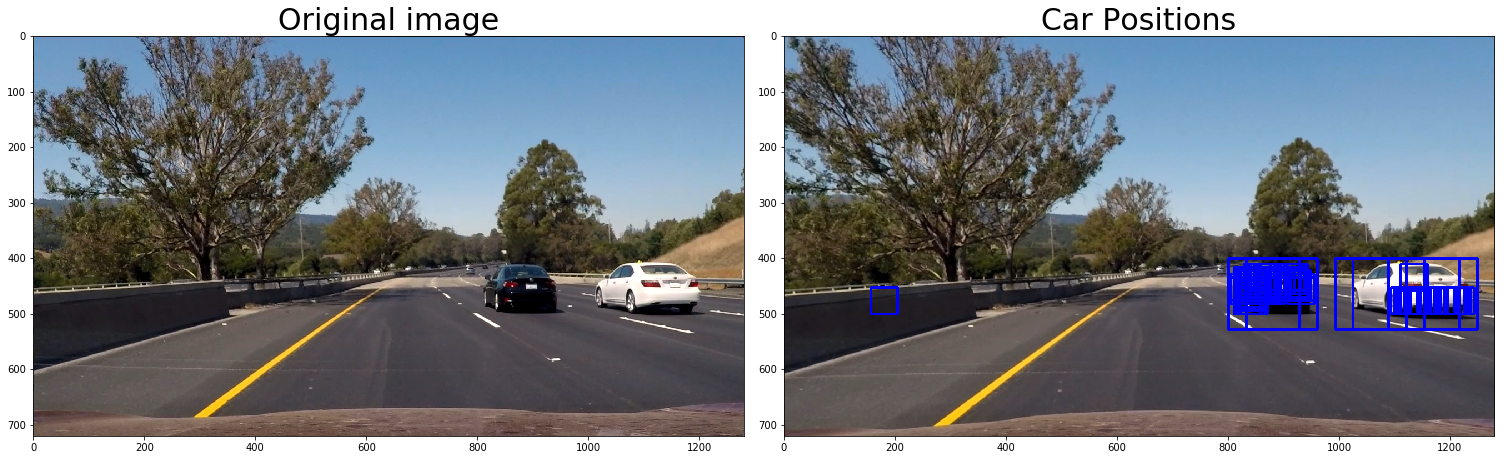

In [6]:
img = cv2.cvtColor(cv2.imread('../test_images/test6.jpg'),cv2.COLOR_BGR2RGB)     
draw_img = camera.undistort(img)

heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
box_list = []
box_list.extend(find_boxes_of_cars(draw_img, 410, 500, 0.75, clf, X_scaler, orient, 
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))
    
box_list.extend(find_boxes_of_cars(draw_img, 400, 660, 2, clf, X_scaler, orient, 
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))

for box in box_list:
    cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 4)

fig = plt.figure(figsize=(21,9))
plt.subplot(121)
plt.imshow(img)
plt.title('Original image',fontsize = 30)
plt.subplot(122)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize = 30)  
fig.tight_layout()


## Show results after threshold filtering

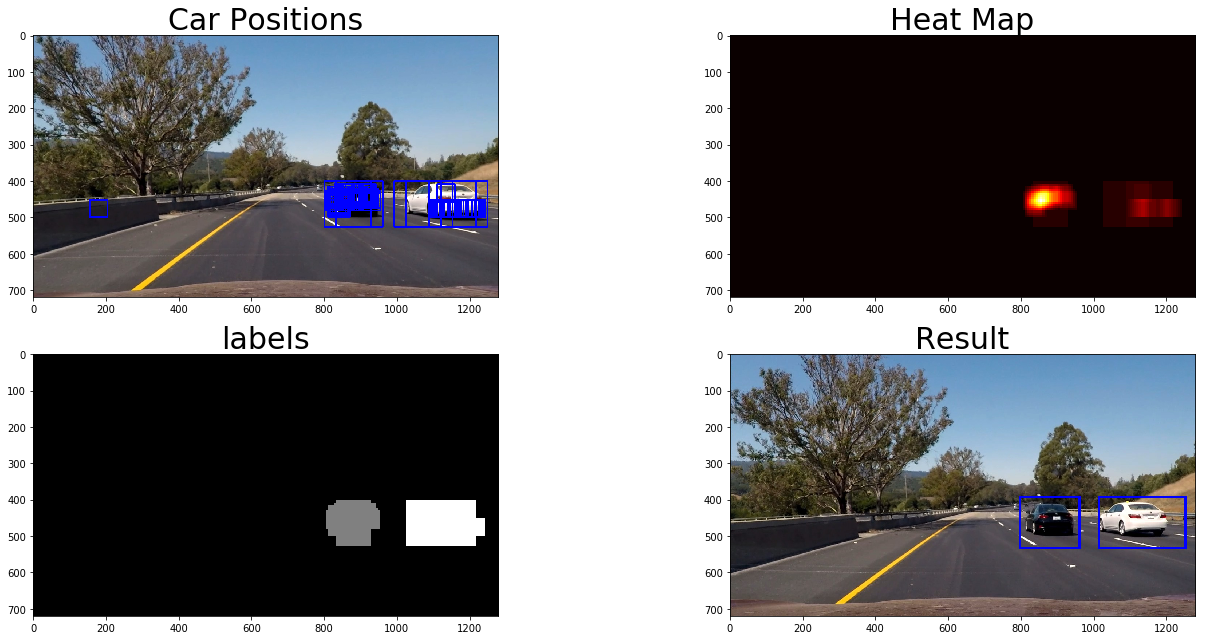

In [7]:
img = cv2.cvtColor(cv2.imread('../test_images/test6.jpg'),cv2.COLOR_BGR2RGB)     
draw_img = camera.undistort(img)

heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
box_list = []
box_list.extend(find_boxes_of_cars(draw_img, 410, 500, 0.75, clf, X_scaler, orient, 
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))

box_list.extend(find_boxes_of_cars(draw_img, 400, 660, 2, clf, X_scaler, orient, 
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))

for box in box_list:
    cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 4)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
# labels1 = verify_label(img,labels)
draw_img_final = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(21,9))
plt.subplot(221)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize = 30)  
plt.subplot(222)
plt.imshow(heat, cmap='hot')
plt.title('Heat Map', fontsize = 30)  

plt.subplot(223)
plt.imshow(labels[0], cmap='gray')
plt.title('labels', fontsize = 30)  
plt.subplot(224)
plt.imshow(draw_img_final, cmap='hot')
plt.title('Result', fontsize = 30)

fig.tight_layout()

## Define Cars() class for filtering out FP based on previous frames

In [8]:
class Cars:
    """
    Define a Cars() class to record labels from previous frames
    """
    def __init__(self):
        
        self.fit = [np.array([False])]
        
        # Initiate deque for smoothing the measurement over the last 'fit_count' frames of video
        self.fit_count = 7
        
        # Initiate variables
        self.counts = 0
        self.fit_deque = deque(self.fit_count*[np.array([False])], self.fit_count)
        self.threshold = (1-1.0/self.fit_count)
        
    def update(self, binary_heat):
        self.fit_deque.pop()
        self.fit_deque.appendleft(binary_heat)
        self.counts += 1
        self.fit = np.zeros_like(binary_heat)
        self.fit[np.mean(list(cars.fit_deque)[:self.counts],axis=0) > self.threshold] = 1        

## Defome Process_image function

In [9]:
def Process_image(img, svc=clf, X_scaler=X_scaler, orient=orient,
                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                  spatial_size=spatial_size, hist_bins=hist_bins):
    
    img = camera.undistort(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list = []

    box_list.extend(find_boxes_of_cars(img, 410, 500, 0.75, clf, X_scaler, orient, 
                                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))


    box_list.extend(find_boxes_of_cars(img, 400, 660, 2, clf, X_scaler, orient, 
                                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Update detected cars
    binary_heat = np.zeros_like(heat)
    binary_heat[(heat >= 1)] = 1
    cars.update(binary_heat)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(cars.fit, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    if cars.counts > 2: # do not show the detectd result in the first 2 frames, which may contain FP.
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    else:
        draw_img = np.copy(img)
    
    return draw_img

## Process video

In [10]:
output = '../output_videos/project_video.mp4'
cars = Cars()
clip = VideoFileClip("../project_video.mp4")#.subclip(22,27)
white_clip = clip.fl_image(Process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output_videos/project_video.mp4
[MoviePy] Writing video ../output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [34:23<00:01,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video.mp4 

CPU times: user 39min 25s, sys: 11.7 s, total: 39min 37s
Wall time: 34min 23s
